# Image Analysis Challenge (Part 1)
Developed by:

**Ahmed Gouda, MAIA**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''Importing required packages'''
import nibabel as nib
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage
from skimage.morphology import remove_small_objects

In [ ]:
'''Load fuctions'''

'''This functions removes connected pixels intensities more than spescific threshold and the small connected objects from a binary mask less than specific size.'''
def undesired_objects (image, image_mask, threshold_val, min_size_val):
    components, n = ndimage.label( image_mask )
    #Remove the small objects.
    components = remove_small_objects(components, min_size = min_size_val)
    #Set labels for the new connected objects. 
    components, n = ndimage.label(components)
    for i in range(0,n+1):
      component_compress = image[components==i]
      component_avg = np.sum(component_compress)/np.shape(component_compress)
      #Convert the components into a mask. 
      if(component_avg>threshold_val):
        components[components==i] = 0;
    components[components>0] = 1
    return(components)

'''This function sets the back ground invert mask to zero'''
def remove_background ( image ):
    #Split the connected objects into different labels.
    components, n = ndimage.label( image )
    #Set the background components into zeros which holds the same corner labels values.
    components[components == components[0][0]] = 0
    components[components == components[components.shape[0]-1][0]] = 0
    components[components == components[0][components.shape[1]-1]] = 0
    components[components == components[components.shape[0]-1][components.shape[1]-1]] = 0
    #Convert the components into a mask.
    components[components > 0]  = 1
    return(components)

'''This function applies hounsfield windowing a certain level and window width.'''
def hounsfield_window ( image,  level, width):
    #Calculate the minimum and maximum window threshold value.
    min_win = level - (int)(width/2)
    max_win = level + (int)(width/2)
    #Apply the min and max threshold to the image.
    image[image<min_win] = min_win
    image[image>max_win] = max_win
    return(image)    
    
'''This function applies image thresholding within a minimum and a maximum range.'''
def image_thershold(image, min_val, max_val):
  image[image<min_val] = min_val
  image[image>max_val] = min_val
  image = image - min_val;
  image[image > 0] = 1
  return(image) 

# 1) Loading the Image



Loading Image: slice018.nii.gz


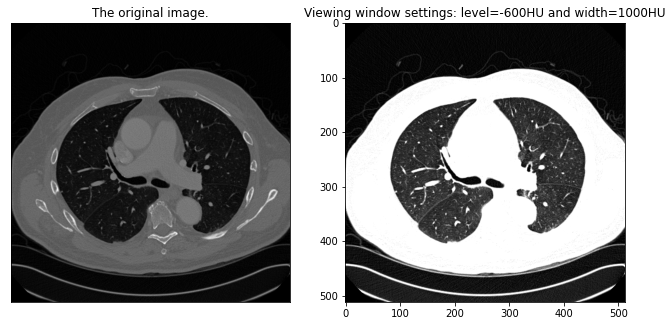

In [ ]:
#Enter patient scan number
patient_scan = 18

#Scan all the images from the directory
scan_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Images/'
scan_files = [f for f in listdir(scan_dir) if 'nii' in f]
scan_files = np.sort(scan_files)

print('Loading Image: '+ scan_files[patient_scan-1])
img_CT = nib.load(scan_dir + scan_files[patient_scan-1])
img_data = np.transpose(img_CT.get_fdata())

#Set the Hounsfield window settings: level=-600HU and width=1000HU (between -1100 HU and  -100HU) just to show the image.
img_hu_win1 = hounsfield_window(np.copy(img_data), level = -600, width = 1000)

plt.figure(figsize=(11, 11))
plt.subplot(121),plt.imshow(img_data, cmap = 'gray')
plt.title('The original image.'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_hu_win1, 'gray')
plt.title('Viewing window settings: level=-600HU and width=1000HU')
plt.show()

# 2) Lung Segmenatation Task



## 1.2. The first lung border invert segmentation mask

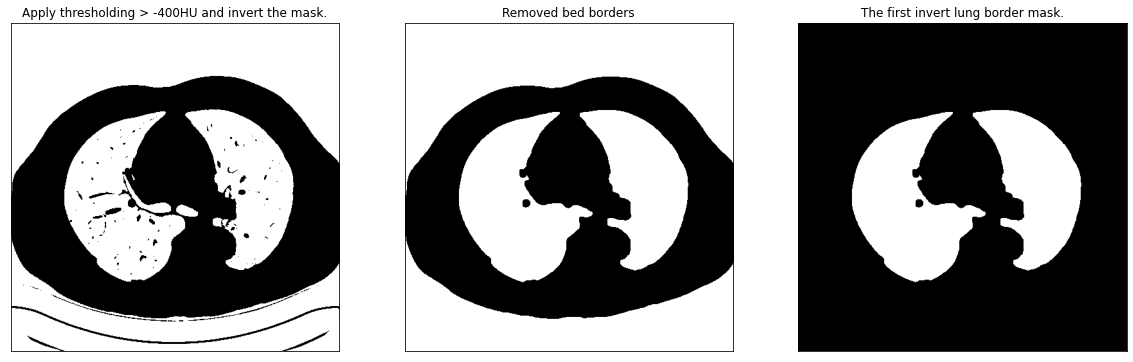

In [ ]:
#Segment all the tissues and the bones that surrounds the lung within the range 700 and 1000, and invert the mask. 
img_data_mask1 = 1 - image_thershold(np.copy(img_data), -400, np.amax(img_data))

#Apply close mophilogical operation to remove the scanner bed borders.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
img_data_mask1_close =  cv2.morphologyEx(img_data_mask1, cv2.MORPH_CLOSE, kernel)

#Remove the background image to obtain the lung invert mask.
im_inv_mask_lung_border = remove_background (img_data_mask1_close)

plt.figure(figsize=(20, 20))
plt.subplot(131),plt.imshow(img_data_mask1, cmap = 'gray')
plt.title('Apply thresholding > -400HU and invert the mask.'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_data_mask1_close, cmap = 'gray')
plt.title('Removed bed borders'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(im_inv_mask_lung_border, cmap = 'gray')
plt.title('The first invert lung border mask.'), plt.xticks([]), plt.yticks([])
plt.show()

## 2.3. The second trachea invert segmentation mask

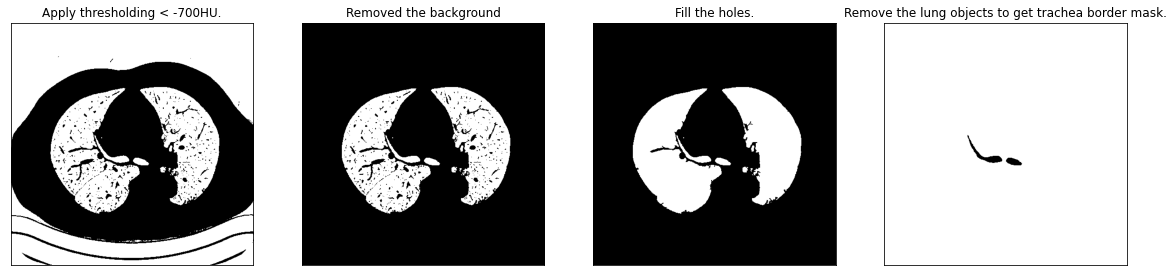

In [ ]:
#Segment the trachea at threshold value < -700 HU. 
img_data_mask2 = np.copy(img_data)
img_data_mask2[img_data_mask2>-700] = 1;
img_data_mask2[img_data_mask2<=-700] = 0;
img_data_mask2 = 1-img_data_mask2

#Remove the backgound using the first invert lung border mask. 
img_data_mask2_mul = im_inv_mask_lung_border * img_data_mask2

#Fill the holes.
img_data_mask2_mul_fill = ndimage.binary_fill_holes(img_data_mask2_mul).astype(int)

#Remove the connected objects > -925 HU and the small connected pixels.
im_inv_mask_trachea = 1 - undesired_objects (np.copy(img_data), np.copy(img_data_mask2_mul_fill), -925, 100)

plt.figure(figsize=(20, 20))
plt.subplot(141),plt.imshow(img_data_mask2, cmap = 'gray')
plt.title('Apply thresholding < -700HU.'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(img_data_mask2_mul, cmap = 'gray')
plt.title('Removed the background'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(img_data_mask2_mul_fill, cmap = 'gray')
plt.title('Fill the holes.'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(im_inv_mask_trachea, cmap = 'gray')
plt.title('Remove the lung objects to get trachea border mask.'), plt.xticks([]), plt.yticks([])
plt.show()


## 2.2. The third lung segmentation mask

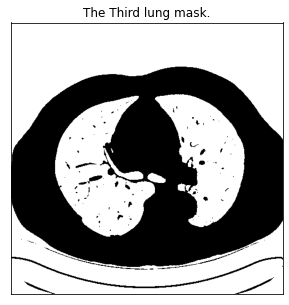

In [ ]:
#Segment all the lung parenchyma within the range -1100 and -400. 
img_data_mask3 =image_thershold(np.copy(img_data), -1100, -400)

plt.figure(figsize=(5, 5))
plt.imshow(img_data_mask3, cmap = 'gray')
plt.title('The Third lung mask.'), plt.xticks([]), plt.yticks([])
plt.show()

## 2.4. Multiply the masks and apply post-processing

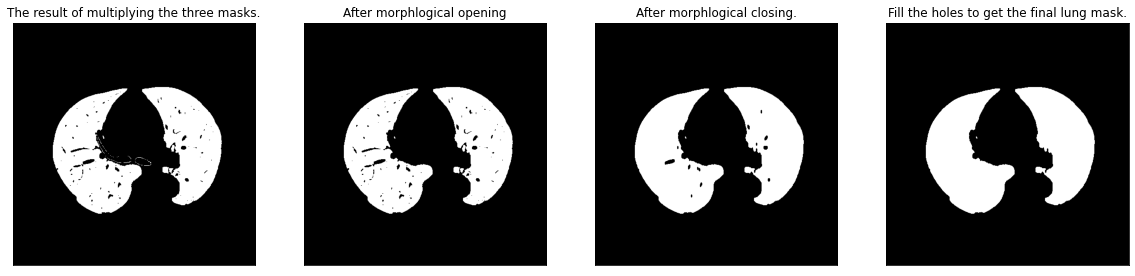

In [ ]:
''' Multiply the three masks to get the final lung mask.''' 
im_mask_lung = im_inv_mask_lung_border * img_data_mask3 * im_inv_mask_trachea

'''Apply post-processing'''
#Close the objects.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
im_mask_lung_open =  cv2.morphologyEx(np.uint8(im_mask_lung), cv2.MORPH_OPEN, kernel)

#Close the objects.
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 7))
im_mask_lung_open_close =  cv2.morphologyEx(np.uint8(im_mask_lung_open), cv2.MORPH_CLOSE, kernel)

#Fill the holes after closing and get the finalmask.
im_mask_lung_final = ndimage.binary_fill_holes(im_mask_lung_open_close).astype(int)

plt.figure(figsize=(20, 20))
plt.subplot(141),plt.imshow(im_mask_lung, cmap = 'gray')
plt.title('The result of multiplying the three masks.'), plt.xticks([]), plt.yticks([])
plt.subplot(142),plt.imshow(im_mask_lung_open, cmap = 'gray')
plt.title('After morphlogical opening'), plt.xticks([]), plt.yticks([])
plt.subplot(143),plt.imshow(im_mask_lung_open_close, cmap = 'gray')
plt.title('After morphlogical closing.'), plt.xticks([]), plt.yticks([])
plt.subplot(144),plt.imshow(im_mask_lung_final, cmap = 'gray')
plt.title('Fill the holes to get the final lung mask.'), plt.xticks([]), plt.yticks([])
plt.show()

## 2.5. Compute the lung area in mm²

In [ ]:
#Calculate the lung area by summing up all mask pixels and multipling the result by the pixels dimentions.
lung_area = np.sum(im_mask_lung_final)*img_CT.header['pixdim'][1]*img_CT.header['pixdim'][2]
print('The lung area is ' + str(lung_area) + ' mm²')

The lung area is 28931.28318786621 mm²


## 2.6. Save the final lung mask

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Output_masks/Lung_masks/'
#Set the mask header file similar to the original header file. 
img_CT_lung_mask = nib.Nifti1Image(np.transpose(im_mask_lung_final), img_CT.affine, img_CT.header)
nib.save(img_CT_lung_mask, save_dir + scan_files[patient_scan-1][0:8]+'_lung_mask.nii.gz')

#3) Vessels Segmentation Task

## 3.1. Segment the vessels

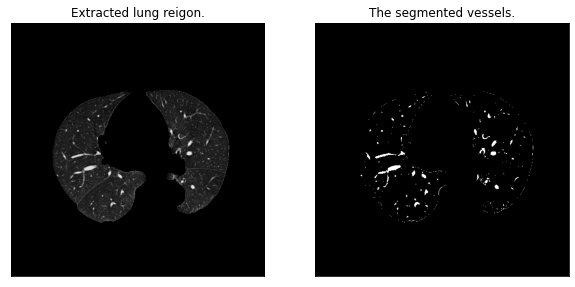

In [ ]:
#Extract the lung reigon from the mask.
img_data_lung = np.copy(img_data)
img_data_lung[im_mask_lung_final==0] = np.amin(img_data_lung)

#Remove the values less than -500
im_mask_vessels = np.copy(img_data_lung)
im_mask_vessels[im_mask_vessels <-500] = -500

#Segment the veesels
im_mask_vessels = im_mask_vessels + 500
im_mask_vessels[im_mask_vessels > 0] = 1

plt.figure(figsize=(10, 10))
plt.subplot(121),plt.imshow(img_data_lung, cmap = 'gray')
plt.title('Extracted lung reigon.'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(im_mask_vessels, cmap = 'gray')
plt.title('The segmented vessels.'), plt.xticks([]), plt.yticks([])
plt.show()

## 3.2. Calculate vessel-lung area ratio

In [ ]:
vessels_lung_ratio = np.sum(im_mask_vessels)*100/np.sum(im_mask_lung_final)

print('The vessel-lung area ratio is ' + str(vessels_lung_ratio) + '%') 

The vessel-lung area ratio is 4.213545113611295%


## 3.3. Save the final vessels mask

In [ ]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/LungTechChallenge/Output_masks/Vessels_masks/'
#Set the mask header file similar to the original header file. 
img_CT_vessels_mask = nib.Nifti1Image(np.transpose(im_mask_vessels), img_CT.affine, img_CT.header)
nib.save(img_CT_vessels_mask, save_dir + scan_files[patient_scan-1][0:8]+'_vessels_mask.nii.gz')